# CrateDB JupySQL Example

[JupySQL], the successor of [ipython-sql], enables running SQL in
Jupyter/IPython per `%sql` and `%%sql` magics. It aims to become
a full-fledged SQL client, compatible with all major databases.

## Setup

To start a single-node instance of CrateDB for evaluation purposes, you can use
Docker or Podman.
```bash
docker run --rm -it --name=cratedb \
  --publish=4200:4200 --publish=5432:5432 \
  --env=CRATE_HEAP_SIZE=2g crate/crate:nightly \
  -Cdiscovery.type=single-node
```

[ipython-sql]: https://github.com/catherinedevlin/ipython-sql
[JupySQL]: https://jupysql.ploomber.io/

In [1]:
# Load extension.
%reload_ext sql

# Connect to CrateDB.
%sql crate://

Connecting to 'crate://'

## Basic querying

In [4]:
# Invoke SQL query and display results.
%sql SELECT * FROM sys.summits ORDER BY height DESC;

Running query in 'crate://'

1605 rows affected.

classification,coordinates,country,first_ascent,height,mountain,prominence,range,region
I/B-07.V-B,"[6.86444, 45.8325]",FR/IT,1786,4808,Mont Blanc,4695,U-Savoy/Aosta,Mont Blanc massif
I/B-09.III-A,"[7.86694, 45.93694]",CH,1855,4634,Monte Rosa,2165,Valais,Monte Rosa Alps
I/B-09.V-A,"[7.85889, 46.09389]",CH,1858,4545,Dom,1046,Valais,Mischabel
I/B-09.III-A,"[7.83556, 45.92222]",CH/IT,1861,4527,Liskamm,376,Valais/Aosta,Monte Rosa Alps
I/B-09.II-D,"[7.71583, 46.10139]",CH,1861,4506,Weisshorn,1235,Valais,Weisshorn-Matterhorn
I/B-09.II-A,"[7.65861, 45.97639]",CH/IT,1865,4478,Matterhorn,1042,Valais/Aosta,Weisshorn-Matterhorn
I/B-09.II-C,"[7.61194, 46.03417]",CH,1862,4357,Dent Blanche,915,Valais,Weisshorn-Matterhorn
I/B-09.I-B,"[7.29917, 45.9375]",CH,1859,4314,Grand Combin,1517,Valais,Grand Combin Alps
I/B-12.II-A,"[8.12611, 46.53722]",CH,1829,4274,Finsteraarhorn,2280,Bern/Valais,Bernese Alps
I/B-09.II-D,"[7.69028, 46.065]",CH,1864,4221,Zinalrothorn,490,Valais,Weisshorn-Matterhorn


## DDL reflection

Inspect tables and table definitions.

In [22]:
%sqlcmd tables --schema sys

Name
allocations
checks
cluster
health
jobs
jobs_log
jobs_metrics
node_checks
nodes
operations


In [21]:
%sqlcmd columns --table sys.summits

name,type,nullable
classification,VARCHAR,True
coordinates,UserDefinedType(),True
country,VARCHAR,True
first_ascent,INTEGER,True
height,INTEGER,True
mountain,VARCHAR,True
prominence,INTEGER,True
range,VARCHAR,True
region,VARCHAR,True


## Variable expansion

JupySQL supports variable expansion of arguments in the form of `{{variable}}`.
Let’s see an example of parametrizing `table` and `schema`:

In [24]:
schema = "sys"
table = "jobs"

%sqlcmd columns --table {{table}} --schema {{schema}}

name,type,nullable
id,VARCHAR,True
node,ObjectTypeImpl(),True
started,TIMESTAMP,True
stmt,VARCHAR,True
username,VARCHAR,True


## Plotting

The [ggplot API] is structured around the principles of the grammar of graphics,
and allows you to build any graph using the same components: a data set, a
coordinate system, and geoms (geometric objects). It is suitable for plotting
larger-than-memory datasets on any laptop.

[ggplot API]: https://jupysql.ploomber.io/en/latest/user-guide/ggplot.html

In [106]:
# Acquire and import data.
from pathlib import Path
from urllib.request import urlretrieve

from csvkit.utilities.csvsql import CSVSQL

if not Path("diamonds.csv").is_file():
    urlretrieve(
        "https://github.com/tidyverse/ggplot2/raw/refs/heads/main/data-raw/diamonds.csv",
        "diamonds.csv",
    )

CSVSQL(args=["--db", "crate://", "--insert", "diamonds.csv", "--overwrite"]).run()

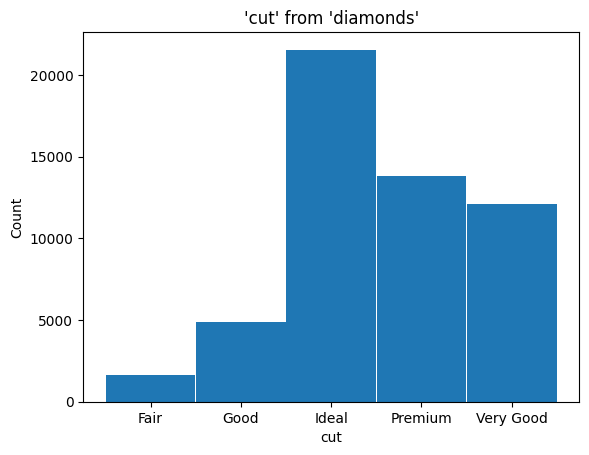

In [89]:
from sql.ggplot import aes, geom_histogram, ggplot

(ggplot("diamonds", aes(x="cut")) + geom_histogram())

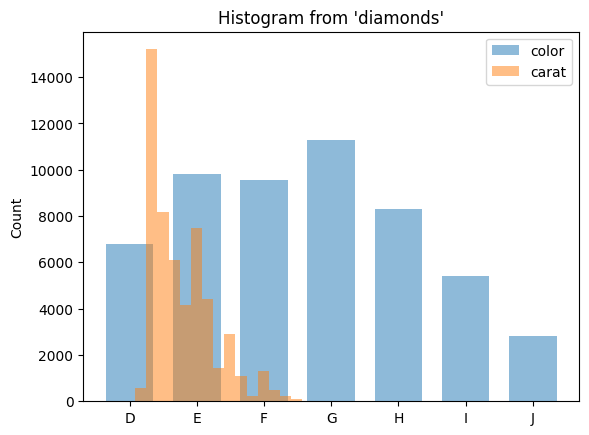

In [11]:
(ggplot("diamonds", aes(x=["color", "carat"])) + geom_histogram(bins=30))

## Parameterizing SQL queries

JupySQL provides powerful SQL parametrization capabilities, either using traditional
`:variable`-style interpolation for SQLAlchemy-compatible databases, or using
Jinja templates for enabling SQL query parametrization with `{{variable}}`.

The latter provides a versatile little programming system providing data filtering,
SQL generation, macros, snippets, and optionally combining all with Python code.

See [JupySQL templating].

[JupySQL templating]: https://jupysql.ploomber.io/en/latest/user-guide/template.html

### Traditional

In [29]:
%config SqlMagic.displaylimit = 20
%config SqlMagic.named_parameters = "enabled"

country = "CH"
region = "%matterhorn%"

In [31]:
%%sql
SELECT *
FROM sys.summits
WHERE
    country = :country
    AND
    region ILIKE :region
ORDER BY height DESC;

Running query in 'crate://'

12 rows affected.

classification,coordinates,country,first_ascent,height,mountain,prominence,range,region
I/B-09.II-D,"[7.71583, 46.10139]",CH,1861,4506,Weisshorn,1235,Valais,Weisshorn-Matterhorn
I/B-09.II-C,"[7.61194, 46.03417]",CH,1862,4357,Dent Blanche,915,Valais,Weisshorn-Matterhorn
I/B-09.II-D,"[7.69028, 46.065]",CH,1864,4221,Zinalrothorn,490,Valais,Weisshorn-Matterhorn
I/B-09.II-D,"[7.66806, 46.03861]",CH,1865,4063,Ober Gabelhorn,536,Valais,Weisshorn-Matterhorn
I/B-09.II-C,"[7.61139, 46.05194]",CH,1865,3962,Grand Cornier,431,Valais,Weisshorn-Matterhorn
I/B-09.II-D,"[7.74556, 46.12583]",CH,1865,3833,Brunegghorn,293,Valais,Weisshorn-Matterhorn
I/B-09.II-C,"[7.63056, 46.02694]",CH,1870,3789,Pointe de Zinal,301,Valais,Weisshorn-Matterhorn
I/B-09.II-A,"[7.52306, 46.03944]",CH,1871,3676,Dent de Perroc,408,Valais,Weisshorn-Matterhorn
I/B-09.II-D,"[7.67111, 46.1425]",CH,1863,3609,Les Diablons,379,Valais,Weisshorn-Matterhorn
I/B-09.II-C,"[7.52528, 46.13861]",CH,1835,3254,Sasseneire,386,Valais,Weisshorn-Matterhorn


### Jinja

In [36]:
%config SqlMagic.displaylimit = 5
%config SqlMagic.named_parameters = "disabled"

country = "CH"
region = "%matterhorn%"

In [37]:
%%sql
SELECT *
FROM sys.summits
WHERE
    country = '{{ country }}'
    AND
    region ILIKE '{{ region }}'
ORDER BY height DESC;

Running query in 'crate://'

12 rows affected.

classification,coordinates,country,first_ascent,height,mountain,prominence,range,region
I/B-09.II-D,"[7.71583, 46.10139]",CH,1861,4506,Weisshorn,1235,Valais,Weisshorn-Matterhorn
I/B-09.II-C,"[7.61194, 46.03417]",CH,1862,4357,Dent Blanche,915,Valais,Weisshorn-Matterhorn
I/B-09.II-D,"[7.69028, 46.065]",CH,1864,4221,Zinalrothorn,490,Valais,Weisshorn-Matterhorn
I/B-09.II-D,"[7.66806, 46.03861]",CH,1865,4063,Ober Gabelhorn,536,Valais,Weisshorn-Matterhorn
I/B-09.II-C,"[7.61139, 46.05194]",CH,1865,3962,Grand Cornier,431,Valais,Weisshorn-Matterhorn


## Parameterizing arguments

In [64]:
%config SqlMagic.displaylimit = 3

table = "summits"

In [41]:
%%sql --save {{table}}
SELECT *
FROM sys.summits

Running query in 'crate://'

1605 rows affected.

classification,coordinates,country,first_ascent,height,mountain,prominence,range,region
I/B-07.V-B,"[6.86444, 45.8325]",FR/IT,1786,4808,Mont Blanc,4695,U-Savoy/Aosta,Mont Blanc massif
I/B-09.III-A,"[7.86694, 45.93694]",CH,1855,4634,Monte Rosa,2165,Valais,Monte Rosa Alps
I/B-09.V-A,"[7.85889, 46.09389]",CH,1858,4545,Dom,1046,Valais,Mischabel


## Profile and explore

In [75]:
%sqlcmd profile --table sys.summits

,classification,coordinates,country,first_ascent,height,mountain,prominence,range,region
count,1605,,1605,600,1605,1605,1605,1605,1605
unique,261,,17,111,1059,1583,614,170,136
top,II/A-15.VI-A,"[10.61417, 46.30861]",IT,nan,nan,Schwarzhorn,nan,North Tyrol,Massif des Écrins
freq,21,2,436,nan,nan,4,nan,150,48
mean,nan,nan,nan,1859.1533,2811.9184,nan,556.1564,nan,nan
min,nan,nan,nan,1358,1996,nan,170,nan,nan
max,nan,nan,nan,1905,4808,nan,4695,nan,nan


In [76]:
%sqlcmd explore --table sys.summits

## pandas

If you have installed `pandas`, you can use a result set’s `.DataFrame()` method,
see [JupySQL pandas integration].

[JupySQL pandas integration]: https://jupysql.ploomber.io/en/latest/integrations/pandas.html

In [83]:
result = %sql SELECT * FROM sys.summits
df = result.DataFrame()
df

Generating CTE with stored snippets: 'summits'

Running query in 'crate://'

1605 rows affected.

,classification,coordinates,country,first_ascent,height,mountain,prominence,range,region
0,I/B-07.V-B,"[6.86444, 45.8325]",FR/IT,1786.0,4808,Mont Blanc,4695,U-Savoy/Aosta,Mont Blanc massif
1,I/B-09.III-A,"[7.86694, 45.93694]",CH,1855.0,4634,Monte Rosa,2165,Valais,Monte Rosa Alps
2,I/B-09.V-A,"[7.85889, 46.09389]",CH,1858.0,4545,Dom,1046,Valais,Mischabel
3,I/B-09.III-A,"[7.83556, 45.92222]",CH/IT,1861.0,4527,Liskamm,376,Valais/Aosta,Monte Rosa Alps
4,I/B-09.II-D,"[7.71583, 46.10139]",CH,1861.0,4506,Weisshorn,1235,Valais,Weisshorn-Matterhorn
...,...,...,...,...,...,...,...,...,...
1600,II/C-29.I-B,"[9.61583, 45.92972]",IT,NaN,1999,Monte Venturosa,471,Bergamo,Bergamo Alps
1601,I/B-08.III-C,"[6.57556, 46.12861]",FR,NaN,1999,Pointe de Marcelly,440,Upper Savoy,Chablais Alps
1602,II/C-33.I-B,"[13.36389, 46.53222]",IT,NaN,1999,Monte Scinauz,369,Udine,Carnic Alps
1603,I/A-02.I-E,"[6.59083, 44.02139]",FR,NaN,1996,Puy de Rent,556,Alpes-de-Haute-Provence,Maritime Alps


## Polars

If you have installed `polars`, you can use a result set’s `.PolarsDataFrame()` method,
see [JupySQL Polars integration].

[JupySQL Polars integration]: https://jupysql.ploomber.io/en/latest/integrations/polars.html

In [85]:
result = %sql SELECT * FROM sys.summits
df = result.PolarsDataFrame()
df

Generating CTE with stored snippets: 'summits'

Running query in 'crate://'

1605 rows affected.

classification,coordinates,country,first_ascent,height,mountain,prominence,range,region
str,list[f64],str,i64,i64,str,i64,str,str
"""I/B-07.V-B""","[6.86444, 45.8325]","""FR/IT""",1786,4808,"""Mont Blanc""",4695,"""U-Savoy/Aosta""","""Mont Blanc massif"""
"""I/B-09.III-A""","[7.86694, 45.93694]","""CH""",1855,4634,"""Monte Rosa""",2165,"""Valais""","""Monte Rosa Alps"""
"""I/B-09.V-A""","[7.85889, 46.09389]","""CH""",1858,4545,"""Dom""",1046,"""Valais""","""Mischabel"""
"""I/B-09.III-A""","[7.83556, 45.92222]","""CH/IT""",1861,4527,"""Liskamm""",376,"""Valais/Aosta""","""Monte Rosa Alps"""
"""I/B-09.II-D""","[7.71583, 46.10139]","""CH""",1861,4506,"""Weisshorn""",1235,"""Valais""","""Weisshorn-Matterhorn"""
…,…,…,…,…,…,…,…,…
"""II/C-29.I-B""","[9.61583, 45.92972]","""IT""",null,1999,"""Monte Venturosa""",471,"""Bergamo""","""Bergamo Alps"""
"""I/B-08.III-C""","[6.57556, 46.12861]","""FR""",null,1999,"""Pointe de Marcelly""",440,"""Upper Savoy""","""Chablais Alps"""
"""II/C-33.I-B""","[13.36389, 46.53222]","""IT""",null,1999,"""Monte Scinauz""",369,"""Udine""","""Carnic Alps"""


:::{todo}
- ggplot: https://jupysql.ploomber.io/en/latest/user-guide/ggplot.html
- boxplot: https://jupysql.ploomber.io/en/latest/user-guide/argument-expansion.html
- pandas persist: https://jupysql.ploomber.io/en/latest/integrations/pandas.html
- compatibility: https://jupysql.ploomber.io/en/latest/integrations/compatibility.html
:::